# Playing with Fourier transforms

Have a look at [this page](http://cns-alumni.bu.edu/~slehar/fourier/fourier.html) for most inspiration regarding this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
%matplotlib inline

Generate a 2D brightness image; note that the minimum brightness is 0 and that no negative values are permitted -- the average brightness is always positive.

In [2]:
def make_img(harmonic,points):
    tmp = np.linspace(0,2*np.pi,points)
    x,xx = np.meshgrid(tmp,tmp)
    x = np.sin(x*2*harmonic+np.pi/2)+1
    return x

Take a look at how the number of points used to compute the sine wave (i.e. the pixels) affects the displayed function. It looks like after about `h=4` the computed wave corresponds to the sum of the one of frequency $1/2h$ plus another of much lower frequency.

In [14]:
@interact(h=(1,20),points=(100,1000))
def plt_sin(h,points):
    tmp = np.linspace(0,2*np.pi,points)
    x = np.sin(tmp*2*h)+1
    fig = plt.figure(figsize=(12,8))
    plt.plot(x)
    plt.plot(x,'o')
    plt.show()

Simulate sampling. Generating sine wave in python corresponds to taking equally spaced points in a $[0,2\pi]$ interval, computing its sine value, and then drawing straight lines between them. In sampling fitting a function to a set of points on an analog signal corresponds to the sine computation here -- but python does not know the continuous function, it just outputs individual computed points (clear??).

(1.0, -4.5769509808878667e-18, -1.0)


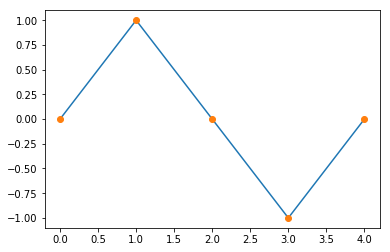

In [15]:
pts = np.linspace(0,2*np.pi,5)
x = np.sin(pts)
plt.plot(x)
plt.plot(x,'o')
print(x.max(), x.mean(), x.min())

Observe the Nyquist frequency. You need to sample at at least twice the frequency you are probing, i.e. you need four times the number of points as the harmonic you want to image. Plus one extra point, since the first and last should be "shared", not possible in this case.

**Actually no**: The required sampling freq is only twice the nyquist freq (highest contained in image); one point per peak/through (2 per cicle), is enough.

In [16]:
@interact(h=(1,100),points=(1,1000))
def plt_sin(h=25,points=101):
    tmp = np.linspace(0,2*np.pi,points)
    x = np.sin(tmp*h)
    plt.plot(x)
    plt.plot(x,'o')
    plt.show()

Observe how the FT changes with increasing odd harmonics.

In [17]:
points = 101
@interact(i=(1,25,2))
def ftrans(i=(1)):
    fig = plt.figure(figsize=(12,6))
    plt.subplot(131)
    plt.imshow(make_img(i,points))
    plt.subplot(132)
    ft = np.fft.fft2(make_img(i,points))
    ft_shift_real = np.real(np.fft.fftshift(ft))
    plt.imshow(ft_shift_real,'bwr')
    plt.show()

Summing higher (odd) harmonics of the image simulates encoding into the image higher and higher frequencies. In principle, at some point one reaches the Nyquist frequency, i.e. the max frequency that can be encoded in the image. Clearly this has to do with the pixel size;

In [53]:
points = 101
@interact(i=(1,25,2))
def plt_harmonics(i=1):
    odd_harmonics = np.arange(1,i+1,2)
    sum_img = make_img(1,points)
    for n in odd_harmonics:
        sum_img = sum_img + make_img(n,points)
    ft = np.fft.fft2(sum_img)
    ft_shift_real = np.real(np.fft.fftshift(ft))
    ###
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(sum_img)
    plt.subplot(142)
    plt.plot(sum_img[50])
    plt.plot(sum_img[50],'x')
    plt.subplot(143)
    plt.imshow(ft_shift_real[30:70,30:70],'bwr')
    plt.subplot(144)
    plt.plot(ft_shift_real[50])
    plt.tight_layout()
    plt.show()

The FT of a variable width square function. 

In [19]:
@interact(i=(0,50))
def plt_delta(i=0):
    delta = np.zeros((102,102))
    if i==0:
        delta[:,50] = 1
    else:
        delta[:,50-i:50+i]=1
    fig = plt.figure(figsize=(11,3))
    plt.subplot(131)
    plt.imshow(delta)
    plt.subplot(132)
    ft = np.fft.fft2(delta)
    ft_shit_real = np.real(np.fft.fftshift(ft))
    plt.imshow(ft_shit_real,'bwr')
    plt.subplot(133)
    plt.plot(ft_shit_real[51])
#     plt.plot(abs(ft_shit_real[51]),'x')
    plt.show()

Generate square wave by summing **odd** harmonics of sine wave:

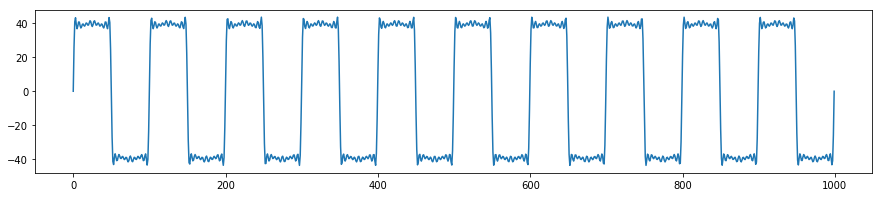

In [26]:
a = 50
x = np.linspace(0,20*np.pi,1000)
odd_harm = np.arange(1,20,2)
sine = np.sin(0)
for n in odd_harm:
    sine = sine + (a/n)*np.sin(n*x)

plt.figure(figsize=(15,3))
plt.plot(sine);

Observe the effect of low pass filtering -- i.e., cutting out the high frequency components of the original image by reconstructing only a limited portion of its FT. Note how this correspond to blurring the image: sharp contours and crisp edges are lost.

**NOTE:** Can achieve the same effect, lowpass filtering, by convolving with a mask that averages together the values of several neighbouring pixels (smoothing).

In [27]:
from scipy import misc

@interact(i=(1,256))
def plt_fiter(i=30):
    img = misc.ascent()

    # FT the image and abs + log to plot it
    img_ft = np.fft.fftshift(np.fft.fft2(img))
    img_ft_plot = np.log(np.abs(img_ft))

    # Make a circular mask -- the ogrid fun spans the whole image
    r = i
    x, y = np.ogrid[-256:256,-256:256]
    mask = x**2 + y**2 >= r**2

    # Copy the FT and mask it
    img_ft_filt = img_ft.copy()
    img_ft_filt[mask] = 0
    img_ft_filt_plot = np.log(np.abs(img_ft_filt))

    # Inv FT the masked FT
    img_ift = np.fft.ifft2(img_ft_filt) # note that I'm not shifting it back!
    img_ift_plot = (np.abs(img_ift))

    # Plot everything
    fig = plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(img)
    plt.subplot(222)
    plt.imshow(img_ft_plot)
    plt.subplot(223)
    plt.imshow(img_ft_filt_plot)
    plt.subplot(224)
    plt.imshow(img_ift_plot)
    plt.show();

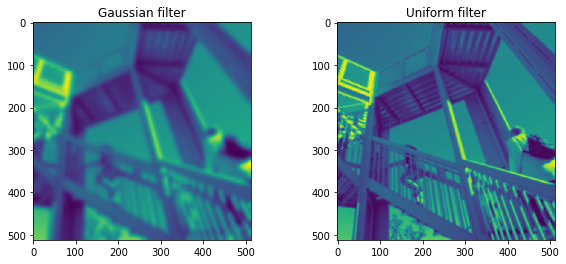

In [28]:
from scipy import ndimage

blurred_img = ndimage.gaussian_filter(misc.ascent(),5)
blurred_img_u = ndimage.uniform_filter(misc.ascent(), size=5)

fig = plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(blurred_img)
plt.title("Gaussian filter")
plt.subplot(122)
plt.title("Uniform filter")
plt.imshow(blurred_img_u)
plt.show()